In [1]:
#FEATURE EXTRACTION
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
import tensorflow


#PREPROCESSING
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#KERAS MODULE
import keras

#IPYTHON
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/valerio/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/valerio/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/valerio/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/valerio/opt/anaconda3/lib/pytho

In [2]:
import logging

# get TF logger
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# create file handler which logs even debug messages
fh = logging.FileHandler('tensorflow.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
log.addHandler(fh)

In [3]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock bamileke bikutsi makossa salsa zouk'.split()
for g in genres:
    pathlib.Path(f'specgrams/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./gtzan/gtzan+/gtzan/{g}'):
        if (filename != '.DS_Store'):
            songname = f'./gtzan/gtzan+/gtzan/{g}/{filename}'
            ipd.Audio(songname)
            y, sr = librosa.load(songname, mono=True, duration=5)
            plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
            plt.axis('off');
            plt.savefig(f'specgrams/{g}/{filename[:-3].replace(".", "")}.png')
            plt.clf()


<Figure size 720x720 with 0 Axes>

In [4]:
####
#
# FEATURES EXTRACTION
#
####

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

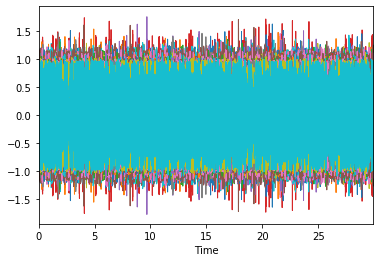

In [5]:
plotting = False; #SET TRUE to store images 

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock bamileke bikutsi makossa salsa zouk'.split()
for g in genres:
    pathlib.Path(f'chromas/{g}').mkdir(parents=True, exist_ok=True)  
    pathlib.Path(f'spectral_centroids/{g}').mkdir(parents=True, exist_ok=True)  
    pathlib.Path(f'spectral_rolloffs/{g}').mkdir(parents=True, exist_ok=True)  
    pathlib.Path(f'zero_crossing_rates/{g}').mkdir(parents=True, exist_ok=True)  
    pathlib.Path(f'mfccs/{g}').mkdir(parents=True, exist_ok=True)  
    for filename in os.listdir(f'./gtzan/gtzan+/gtzan/{g}'):
        if (filename != '.DS_Store'):
            songname = f'./gtzan/gtzan+/gtzan/{g}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30)
            ##Chroma Extraction
            hop_length = 512
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            if(plotting):
                fig = plt.Figure()
                canvas = FigureCanvas(fig)
                ax = fig.add_subplot(111)
                p = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
                plt.savefig(f'chromas/{g}/{filename[:-3].replace(".", "")}.png')
                        
            ##RMSE Extraction
            rmse = librosa.feature.rms(y=y)
            
            ##SPECTRAL CENTROIDD Extraction
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            if(plotting):
                frames = range(len(spec_cent))
                t = librosa.frames_to_time(frames)
                #Normalization for plotting
                def normalize(x, axis=0):
                    return sklearn.preprocessing.minmax_scale(x, axis=axis)

                #Plotting the Spectral Centroid along the waveform
                fig = plt.Figure()
                canvas = FigureCanvas(fig)
                ax = fig.add_subplot(111)
                p = librosa.display.waveplot(y, sr=sr, alpha=0.4)
                plt.savefig(f'spectral_centroids/{g}/{filename[:-3].replace(".", "")}.png')
            
            ##SPECTRAL BANDWIDTH Extraction
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            
            ##SPECTRAL ROLLOFF Extraction
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            if(plotting):
                fig = plt.Figure()
                canvas = FigureCanvas(fig)
                ax = fig.add_subplot(111)
                p = librosa.display.waveplot(y, sr=sr, alpha=0.4)
                plt.savefig(f'spectral_rolloffs/{g}/{filename[:-3].replace(".", "")}.png')

                librosa.display.waveplot(y, sr=sr, alpha=0.4)
                plt.plot(t, normalize(rolloff), color='r')
            
            ##ZERO CROSSING RATE Extraction
            zcr = librosa.feature.zero_crossing_rate(y)
            if(plotting):
                plt.figure(figsize=(14, 5))
                p = librosa.display.waveplot(y, sr=sr)
                n0 = 9000
                n1 = 9100
                plt.figure(figsize=(14, 5))
                plt.plot(y[n0:n1])
                plt.grid()
                plt.savefig(f'zero_crossing_rates/{g}/{filename[:-3].replace(".", "")}.png')
                print(sum(zcr))
            
            ##MFCC Extraction
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            librosa.display.waveplot(y, sr=sr)
            if(plotting):
                print(mfcc.mean(axis=1))
                print(mfcc.var(axis=1))
                fig = plt.Figure()
                canvas = FigureCanvas(fig)
                ax = fig.add_subplot(111)
                p = librosa.display.specshow(mfcc, sr=sr, x_axis='time')
                plt.savefig(f'mfccs/{g}/{filename[:-3].replace(".", "")}.png')
            
            
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {g}'
            file = open('data.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())


In [62]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00093.wav,0.377718,0.065929,567.781110,985.672244,926.652730,0.021671,-350.434875,169.547821,31.805933,...,1.836656,-5.982432,-5.261812,-0.221226,-1.779513,-3.714277,0.177708,2.085259,-2.915131,blues
1,blues.00087.wav,0.336799,0.158134,1437.171843,1861.103461,3073.606414,0.050874,-155.816849,126.074715,1.169325,...,-0.731195,-7.752730,0.352385,-6.914513,3.840950,-6.060226,0.718097,2.302958,-6.059613,blues
2,blues.00050.wav,0.400878,0.182425,1940.164497,2073.403481,4165.541478,0.085770,-83.722748,108.094643,-26.341349,...,12.799378,-9.901252,2.570096,-6.187880,2.777636,-8.396534,-0.753197,-2.452169,0.096195,blues
3,blues.00044.wav,0.390259,0.136312,2271.340093,2365.322755,5184.810315,0.092528,-110.560097,88.396736,-10.054119,...,11.551206,-5.391161,4.112158,-12.835077,12.172639,0.340357,-1.200125,-4.527768,2.578682,blues
4,blues.00078.wav,0.414210,0.258081,2326.644761,2217.409252,4928.736863,0.123754,-3.655516,102.840385,-35.482620,...,13.027472,-13.721716,6.285656,-9.068033,4.879145,-11.022139,2.703297,-3.953358,-4.784192,blues


In [63]:
data.shape

(1500, 28)

In [64]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [65]:
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.377718,0.065929,567.781110,985.672244,926.652730,0.021671,-350.434875,169.547821,31.805933,16.706123,...,1.836656,-5.982432,-5.261812,-0.221226,-1.779513,-3.714277,0.177708,2.085259,-2.915131,blues
1,0.336799,0.158134,1437.171843,1861.103461,3073.606414,0.050874,-155.816849,126.074715,1.169325,46.212624,...,-0.731195,-7.752730,0.352385,-6.914513,3.840950,-6.060226,0.718097,2.302958,-6.059613,blues
2,0.400878,0.182425,1940.164497,2073.403481,4165.541478,0.085770,-83.722748,108.094643,-26.341349,58.107307,...,12.799378,-9.901252,2.570096,-6.187880,2.777636,-8.396534,-0.753197,-2.452169,0.096195,blues
3,0.390259,0.136312,2271.340093,2365.322755,5184.810315,0.092528,-110.560097,88.396736,-10.054119,65.891708,...,11.551206,-5.391161,4.112158,-12.835077,12.172639,0.340357,-1.200125,-4.527768,2.578682,blues
4,0.414210,0.258081,2326.644761,2217.409252,4928.736863,0.123754,-3.655516,102.840385,-35.482620,43.023518,...,13.027472,-13.721716,6.285656,-9.068033,4.879145,-11.022139,2.703297,-3.953358,-4.784192,blues


In [66]:
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock',
 'bamileke',
 'bikutsi',
 'makossa',
 'salsa',
 'zouk']

In [67]:
genre_list = data.iloc[:, -1]


In [68]:
genre_list

0       blues
1       blues
2       blues
3       blues
4       blues
        ...  
1495     zouk
1496     zouk
1497     zouk
1498     zouk
1499     zouk
Name: label, Length: 1500, dtype: object

In [69]:
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [70]:
y

array([ 2,  2,  2, ..., 14, 14, 14])

In [71]:
print ("Predicted Values: ") 
for i in range(len(y)): 
    print (str(y[i])+" "+str(genres[y[i]]))

Predicted Values: 
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2 country
2

In [72]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [73]:
X

array([[ 0.06003966, -1.24680145, -2.72189308, ..., -0.52773727,
         1.65806161, -0.8160514 ],
       [-0.5123124 , -0.01508213, -1.2708007 , ..., -0.40063994,
         1.71277967, -1.53226074],
       [ 0.38399721,  0.30941988, -0.43126011, ..., -0.74668255,
         0.51759029, -0.13017081],
       ...,
       [-0.16008603,  1.94965252,  0.44863148, ...,  0.07754642,
        -1.09212831,  0.16154534],
       [ 0.00392055,  2.1120597 ,  0.33647192, ...,  0.82692282,
        -0.29362946,  1.1303863 ],
       [ 0.19232417,  1.9879326 ,  0.61717374, ...,  0.68461149,
        -0.94892718,  0.46950931]])

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print("Number of train data: "+str(len(y_train))+"\n")
print("Number of test data: "+str(len(y_test))+"\n")
print("Example of data: \n")
X_train[10]

Number of train data: 1005

Number of test data: 495

Example of data: 



array([ 1.99968976,  0.14675573,  0.27857475, -0.12703937,  0.16548163,
        0.24816261,  0.63186053, -0.28863777, -1.13119925,  1.21172656,
       -0.70454297,  1.2690039 , -0.253317  ,  1.75132735,  0.0735573 ,
        0.5377737 ,  0.1034975 ,  1.31760624, -0.28234082,  0.8927885 ,
        0.0286691 ,  1.06004818,  0.3853656 ,  0.79058175,  1.35345356,
        0.32687492])

In [75]:
y_train

array([ 0, 10,  8, ..., 14,  8, 13])

In [76]:
y_test

array([ 6,  3,  2, 14,  2, 13,  7,  6, 11,  5,  4,  3, 10,  4,  4,  9,  9,
       12, 10,  6,  9,  8, 11,  1,  5, 13,  7,  7,  5,  0,  8,  9,  8,  4,
        2,  7, 13, 11,  0,  9, 12,  5, 12,  7,  3,  6, 10,  0,  3, 11,  3,
       12, 13, 11, 10,  9, 14,  6, 13,  6, 10, 14,  4, 10, 11,  3,  2,  0,
       14,  2, 11,  5,  1,  6, 14,  9,  2,  6,  4, 13,  9,  1,  6,  5,  2,
        3,  2, 11,  5, 13, 13, 13, 11, 11,  9,  3,  7,  4,  9,  8, 14,  9,
        8, 13, 10,  9,  9, 12, 13,  2,  0,  3,  8, 10,  9, 14,  4, 13,  8,
        3,  9, 12,  7,  4, 14,  5,  1,  1,  6, 10, 14, 14, 11,  6,  2, 11,
        8,  7,  6,  7,  3,  4,  9,  1,  3,  9,  1,  3,  5,  1,  2,  3, 10,
        8,  5,  8,  2, 11,  2, 10,  5,  6,  7,  0, 11,  8,  1,  7,  9,  3,
        2,  3,  2, 14, 11,  6, 11,  3,  6,  4,  8, 10,  1,  4,  1, 12, 10,
        2,  2, 10,  2,  7,  8,  0,  1,  3,  4, 11, 13, 12,  7, 13,  4,  6,
        0,  7,  5,  3,  0,  2, 10,  4,  7,  5, 12,  0,  5,  9,  8, 14, 13,
        9,  3, 12,  7,  4

In [77]:
X_train.shape

(1005, 26)

In [78]:
####
#
# MODEL BUILDING
#
####
from keras import models
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv1D, Conv2D, Flatten, BatchNormalization, ZeroPadding2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping

def create_model():
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(15, activation='softmax'))

    return model


In [79]:
create_model().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               13824     
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_20 (Dense)             (None, 15)                975       
Total params: 187,279
Trainable params: 187,279
Non-trainable params: 0
_________________________________________________________________


In [80]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
acc_per_fold = []
loss_per_fold = []
model = create_model()

fold_no = 1

# define 10-fold cross validation test 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, y):
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Training
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(X[train], y[train], epochs=8,batch_size=125)
    # evaluate
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0]) 
    
    fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/8
1350/1350 [==============================] - 0s 242us/step - loss: 2.4149 - accuracy: 0.2430
Epoch 2/8
1350/1350 [==============================] - 0s 37us/step - loss: 1.6692 - accuracy: 0.4852
Epoch 3/8
1350/1350 [==============================] - 0s 45us/step - loss: 1.2484 - accuracy: 0.5815
Epoch 4/8
1350/1350 [==============================] - 0s 40us/step - loss: 1.0493 - accuracy: 0.6400
Epoch 5/8
1350/1350 [==============================] - 0s 33us/step - loss: 0.9102 - accuracy: 0.6896
Epoch 6/8
1350/1350 [==============================] - 0s 42us/step - loss: 0.8020 - accuracy: 0.7415
Epoch 7/8
1350/1350 [==============================] - 0s 43us/step - loss: 0.7377 - accuracy: 0.7563
Epoch 8/8
1350/1350 [==============================] - 0s 42us/step - loss: 0.6753 - accuracy: 0.7726
Score for fold 1: loss of 0.8937965170542399; accuracy of 68.00000071525574%
---------

1350/1350 [==============================] - 0s 33us/step - loss: 0.0423 - accuracy: 0.9874
Epoch 3/8
1350/1350 [==============================] - 0s 38us/step - loss: 0.0351 - accuracy: 0.9911
Epoch 4/8
1350/1350 [==============================] - 0s 35us/step - loss: 0.0212 - accuracy: 0.9978
Epoch 5/8
1350/1350 [==============================] - 0s 33us/step - loss: 0.0188 - accuracy: 0.9956
Epoch 6/8
1350/1350 [==============================] - 0s 33us/step - loss: 0.0151 - accuracy: 0.9970
Epoch 7/8
1350/1350 [==============================] - 0s 40us/step - loss: 0.0113 - accuracy: 0.9985
Epoch 8/8
1350/1350 [==============================] - 0s 37us/step - loss: 0.0146 - accuracy: 0.9970
Score for fold 9: loss of 0.02473187121252219; accuracy of 99.33333396911621%
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/8
1350/1350 [==============================] - 0s 294us/step - loss: 0.0499 - accuracy: 0.9830
Epoch 2/8
1350/13

In [81]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.8937965170542399 - Accuracy: 68.00000071525574%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7022432327270508 - Accuracy: 76.66666507720947%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.41015029350916543 - Accuracy: 86.00000143051147%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.41893383900324505 - Accuracy: 86.66666746139526%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.17046190480391185 - Accuracy: 93.99999976158142%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.08212893466154735 - Accuracy: 98.66666793823242%
--------------------------------------------------------------------

In [82]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.67%


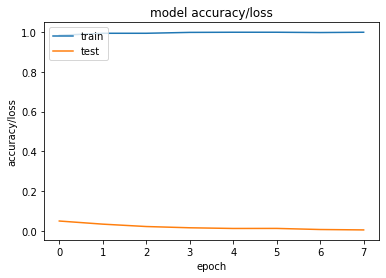

In [83]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy/loss')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
########################################################
#
# Store HDF5 file model
#
########################################################

model_filename = "genre_classifier_nn.h5"
print("Saving model: " + model_filename)
model.model.save(model_filename)   

Saving model: genre_classifier_nn.h5


In [85]:
####
#
# PREDICTION
#
####

predictions = model.predict(X_test)
predictions[0].shape

(15,)

In [86]:
np.sum(predictions[0])

1.0

In [87]:
np.argmax(predictions[0])

6

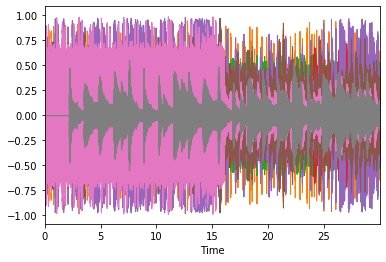

In [88]:
####
#
# AUDIO PREDICTION, TESTING MODEL
#
####
plotting = False;

file = open('data_prediction.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock bamileke bikutsi makossa salsa zouk'.split()
for filename in os.listdir(f'./audio/'):
        if (filename != '.DS_Store'):
            songname = f'./audio/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30)
            ##Chroma Extraction
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
                        
            ##RMSE Extraction
            rmse = librosa.feature.rms(y=y)
            
            ##SPECTRAL CENTROIDD Extraction
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            
            ##SPECTRAL BANDWIDTH Extraction
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            
            ##SPECTRAL ROLLOFF Extraction
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            
            ##ZERO CROSSING RATE Extraction
            zcr = librosa.feature.zero_crossing_rate(y)
            ##MFCC Extraction
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            librosa.display.waveplot(y, sr=sr)
             
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            #to_append += f' {g}'
            file = open('data_prediction.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())


In [89]:
data_pred = pd.read_csv('data_prediction.csv')
data_pred

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,pop_music.mp3,0.254314,0.095018,978.382629,1013.775066,1746.172774,0.062386,-259.897491,184.658325,-45.800884,...,-12.218218,-14.451784,-10.630217,-8.438236,-10.696251,-3.867090,-4.334290,-4.918386,-3.357694,NaN
1,metal_music.mp3,0.481656,0.136116,3030.634570,2637.425523,6025.705230,0.138454,-72.360306,50.188267,-8.358362,...,11.431957,0.709857,-0.451704,-7.950400,5.788267,-6.568089,0.768656,-0.430696,1.963856,NaN
2,disco_music.mp3,0.398332,0.169905,1189.141126,1890.986633,2617.542505,0.034994,-205.434845,139.298157,46.936932,...,2.463606,0.639657,-1.353955,-8.017365,-2.529793,-4.754376,-0.359706,-4.431480,-3.431741,NaN
3,classical_music.mp3,0.218756,0.106082,774.786368,729.941833,1347.216854,0.057496,-286.422516,207.805771,-13.413453,...,-8.638429,-1.653201,3.228821,-0.343572,-5.741215,-7.039397,-2.525050,-2.724466,-6.252247,NaN
4,reggae_music.mp3,0.393193,0.221051,2163.718848,2483.544536,4771.587814,0.077269,-139.669937,87.467918,14.144335,...,9.516438,3.773517,9.792424,0.804042,5.447682,-4.500303,-5.011721,-7.340166,2.411135,NaN
5,country_music.mp3,0.369236,0.141629,1649.428708,2000.295926,3550.961861,0.067497,-136.269760,114.333565,-5.449998,...,2.367076,-4.135781,1.057821,-0.439963,4.482590,-6.745061,-0.547662,-1.635119,-0.660234,NaN
6,hip-hop_music.mp3,0.463836,0.271052,1276.274670,1508.632721,2534.743006,0.048027,-198.170395,115.978401,-21.922701,...,-7.803081,-2.554131,4.350107,1.413619,4.128120,9.210181,6.497707,-3.904041,-2.862355,NaN
7,jazz_music.mp3,0.408057,0.079754,1881.245926,2319.466445,4494.022825,0.042770,-232.800171,82.474869,9.265019,...,-5.184018,-4.996983,-0.210521,-1.085993,2.500464,-2.459925,1.043873,-4.728684,1.789027,NaN


In [90]:
filename_data = data_pred['filename']
data_pred = data_pred.drop(['filename'],axis=1)
#genre_list = data_pred.iloc[:, -1]
#encoder = LabelEncoder()
#pred_y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
pred_X = scaler.fit_transform(np.array(data_pred.iloc[:, :-1], dtype = float))

In [91]:
data_pred.iloc[:, :-1]

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.254314,0.095018,978.382629,1013.775066,1746.172774,0.062386,-259.897491,184.658325,-45.800884,21.104919,...,-9.013398,-12.218218,-14.451784,-10.630217,-8.438236,-10.696251,-3.867090,-4.334290,-4.918386,-3.357694
1,0.481656,0.136116,3030.634570,2637.425523,6025.705230,0.138454,-72.360306,50.188267,-8.358362,53.555698,...,1.673070,11.431957,0.709857,-0.451704,-7.950400,5.788267,-6.568089,0.768656,-0.430696,1.963856
2,0.398332,0.169905,1189.141126,1890.986633,2617.542505,0.034994,-205.434845,139.298157,46.936932,28.534168,...,-3.259843,2.463606,0.639657,-1.353955,-8.017365,-2.529793,-4.754376,-0.359706,-4.431480,-3.431741
3,0.218756,0.106082,774.786368,729.941833,1347.216854,0.057496,-286.422516,207.805771,-13.413453,-15.378023,...,-8.634786,-8.638429,-1.653201,3.228821,-0.343572,-5.741215,-7.039397,-2.525050,-2.724466,-6.252247
4,0.393193,0.221051,2163.718848,2483.544536,4771.587814,0.077269,-139.669937,87.467918,14.144335,28.021185,...,-2.684644,9.516438,3.773517,9.792424,0.804042,5.447682,-4.500303,-5.011721,-7.340166,2.411135
5,0.369236,0.141629,1649.428708,2000.295926,3550.961861,0.067497,-136.269760,114.333565,-5.449998,58.048077,...,0.846613,2.367076,-4.135781,1.057821,-0.439963,4.482590,-6.745061,-0.547662,-1.635119,-0.660234
6,0.463836,0.271052,1276.274670,1508.632721,2534.743006,0.048027,-198.170395,115.978401,-21.922701,13.898983,...,-6.739752,-7.803081,-2.554131,4.350107,1.413619,4.128120,9.210181,6.497707,-3.904041,-2.862355
7,0.408057,0.079754,1881.245926,2319.466445,4494.022825,0.042770,-232.800171,82.474869,9.265019,35.023087,...,-6.193241,-5.184018,-4.996983,-0.210521,-1.085993,2.500464,-2.459925,1.043873,-4.728684,1.789027


In [92]:
filename_data

0          pop_music.mp3
1        metal_music.mp3
2        disco_music.mp3
3    classical_music.mp3
4       reggae_music.mp3
5      country_music.mp3
6      hip-hop_music.mp3
7         jazz_music.mp3
Name: filename, dtype: object

In [93]:
pred_X

array([[-1.37276186, -0.93688918, -0.92988908, -1.2541752 , -1.08410802,
        -0.12344618, -1.02767112,  1.25054509, -1.66450265, -0.31227867,
         0.00951727, -0.86692352, -1.4232815 , -1.3833949 , -0.23963564,
        -1.39340015, -1.24868796, -1.36894325, -2.26170351, -2.08470078,
        -1.34479075, -1.95444918, -0.10595231, -1.11272502, -0.57496681,
        -0.69501738],
       [ 1.24742068, -0.26792324,  2.05394337,  1.26220863,  1.74514866,
         2.39678908,  1.78506209, -1.46686969, -0.20583149,  1.18987778,
         0.29296886,  0.52203448,  0.58978377,  0.98992604,  0.88709818,
         1.4325708 ,  1.55312684,  1.51913518,  0.68980376, -0.21567631,
        -1.2239959 ,  0.9431966 , -0.64941355,  0.39112229,  1.6604758 ,
         1.10244464],
       [ 0.28709026,  0.28206875, -0.62346079,  0.10535449, -0.50803373,
        -1.03095525, -0.21082568,  0.33389202,  1.948341  ,  0.03162352,
         1.11218415,  0.3524823 ,  1.27814749,  1.07240512,  0.0814287 ,
       

In [94]:
predictions = model.predict(pred_X)

In [95]:
predictions[0].shape

(15,)

In [96]:
predictions

array([[2.87355331e-04, 1.68017970e-13, 1.16813739e-04, 1.65088477e-05,
        7.19702875e-05, 4.27153846e-03, 2.16158270e-07, 2.21669598e-05,
        3.45709472e-04, 7.45624743e-11, 5.31275831e-02, 2.59293120e-06,
        9.41691220e-01, 3.16319120e-06, 4.31772060e-05],
       [3.30486263e-11, 1.79999348e-04, 2.69087868e-05, 1.17399823e-09,
        6.39898837e-01, 2.21649222e-02, 3.82709286e-09, 8.00136988e-08,
        2.32121261e-06, 9.08162565e-06, 1.47618495e-09, 5.15258421e-07,
        4.30433204e-07, 3.37705523e-01, 1.12826965e-05],
       [9.72849503e-03, 2.73857881e-10, 4.66852546e-01, 4.88076662e-11,
        4.39852185e-04, 2.32248276e-04, 2.11745760e-06, 8.86161255e-10,
        8.46245214e-02, 7.08504277e-09, 6.73032249e-04, 3.19825231e-05,
        9.09317809e-04, 3.00425313e-07, 4.36505646e-01],
       [9.45237888e-10, 1.35942664e-14, 2.53329972e-06, 9.96633828e-01,
        4.19033604e-05, 5.25459336e-06, 2.66431414e-07, 3.03771673e-03,
        2.15007762e-10, 9.35230422e-1

In [97]:
results = model.predict_classes(pred_X, verbose=0)

In [98]:
results

array([12,  4,  2,  3, 10,  8,  6,  5])

In [99]:
print ("Predicted Values: ") 
for i in range(len(results)): 
    print (str(filename_data[i])+" "+str(results[i])+" "+str(genres[results[i]]))

Predicted Values: 
pop_music.mp3 12 makossa
metal_music.mp3 4 hiphop
disco_music.mp3 2 country
classical_music.mp3 3 disco
reggae_music.mp3 10 bamileke
country_music.mp3 8 reggae
hip-hop_music.mp3 6 metal
jazz_music.mp3 5 jazz
